## Due date: Friday, 2 April 2021, 11:59 PM

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
def saveto(filename):
    plt.savefig('LaTeX Report/figures/'+ filename)

def saveimg(filename, image):
    cv.imwrite('LaTeX Report/figures/'+ filename,image)

def sigmoid(hypothesis):
    return 1/(1+ np.exp(-hypothesis))
         

In [3]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)
#print(y_train[0:10])

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Normalize pixel values: Image data preprocessing
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('Reshaped x_train: ', x_train.shape)
print('Reshaped x_test: ', x_test.shape)
print("Pre-processing completed.")

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


# Part 1

[Reference1](https://cs231n.github.io/linear-classify/)

A part of the code for a linear classifier for CIFAR10 given in listing 1. For our linear classifier, the score function is f (x) = Wx + b, and the loss function is the mean sum of squared errors function. [3 marks]
1. Implement gradient descent and run for 300 epochs.
2. Show the weights matrix W as 10 images.
3. Report the (initial) learning rate, training and testing loss and accuracies.

(Hint: If your loss explodes, reduce the leaning rate.)
* [np.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html), [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical), [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html), [numpy.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [4]:
# Local function definitions for part 1

def getAccuracy(predictions,labels):
    pred_class = np.argmax(predictions, axis=1)
    real_class = np.argmax(labels, axis=1)
    valid_pred = [pred_class == real_class]
    return 100*np.sum(valid_pred)/len(real_class)

In [21]:
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu
w1 = std*np.random.randn(Din, K) # Initializing the weight matrix with random weights
b1 = np.zeros(K) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)

# Keep track of two sets of parameters w1 and b1 seperately is not really efficient.
# This can be eiliminated by combining both of them into one single matrix as follows.
# Aditionally the bias term '1' must be added infront of each image row, for this to wrok.
# i.e to enable matrix multiplication.

print("Rearranging train and test samples...")

# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrix and bias matrix into single matrix
w1 = np.concatenate((b1.reshape(1,K), w1), axis=0); print('Rearranged w1: ',w1.shape)

print("Rearranging completed.\n")

#------------------------------------------------------------------------------------------

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
lr_hitory = []
loss_history = [] # Vlaues of loss function at each iteration 
train_acc_history = [] # Training accuracy
val_acc_history = [] # Validation accuracy

m = x_train.shape[0]  # Number of training examples

# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):    
    # Forward Propagation
    hypothesis = x_train_ra.dot(w1)
    loss = (1/(2*m))*np.sum(( hypothesis - y_train)**2) + (1/(2*m))*reg*np.sum(w1**2) 
    loss_history.append(loss)
    
    # Training Accuracy and Validation Accuracy
    train_acc = getAccuracy(hypothesis, y_train)
    train_acc_history.append(train_acc)
    valid_acc = getAccuracy(x_test_ra.dot(w1), y_test)
    val_acc_history.append(valid_acc)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.5f} | Training Acc: {:.5f} | Validation Acc: {:.5f} | Learning Rate: {:.5f} |"\
             .format(t,loss,train_acc,valid_acc,lr))
    
    # Backward Propagation
    dw1 = (1/m)*(x_train_ra.T.dot(hypothesis - y_train))  + (1/m)*reg*w1 
    w1 = w1 - lr*dw1
    
    # Decaying learning rate
    lr_hitory.append(lr)
    lr = lr*lr_decay
   
print("Gradient Descent completed. Parameters were trained")   

Initializing the weight matrix with random weights...
w1: (3072, 10)
b1: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 10)
Rearranging completed.

Running gradient descent...
| Epoch 001 | Loss 0.49999 | Training Acc: 10.33600 | Validation Acc: 10.40000 | Learning Rate: 0.01400 |
| Epoch 030 | Loss 0.42967 | Training Acc: 36.46400 | Validation Acc: 36.25000 | Learning Rate: 0.01360 |
| Epoch 060 | Loss 0.41264 | Training Acc: 38.09000 | Validation Acc: 38.10000 | Learning Rate: 0.01320 |
| Epoch 090 | Loss 0.40489 | Training Acc: 38.96800 | Validation Acc: 38.90000 | Learning Rate: 0.01281 |
| Epoch 120 | Loss 0.40095 | Training Acc: 39.55400 | Validation Acc: 39.19000 | Learning Rate: 0.01243 |
| Epoch 150 | Loss 0.39873 | Training Acc: 39.93400 | Validation Acc: 39.39000 | Learning Rate: 0.01206 |
| Epoch 180 | Loss 0.39734 | Training Acc: 40.20400 | Validation Acc: 39.53000 | Learning Rate: 0.01170 |
| Epoch 210 | Loss 0.39638 

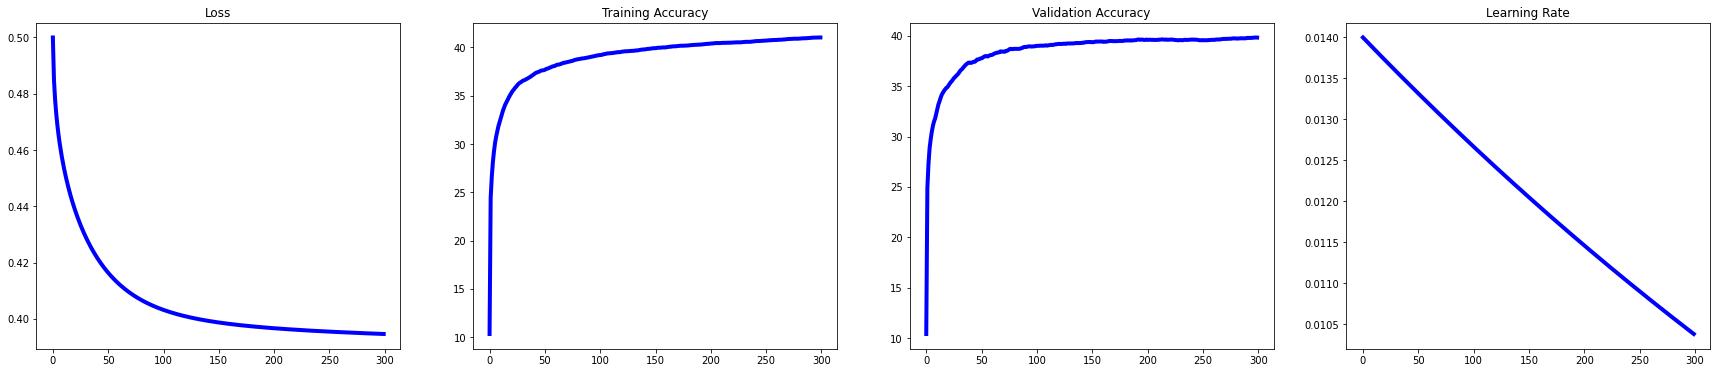

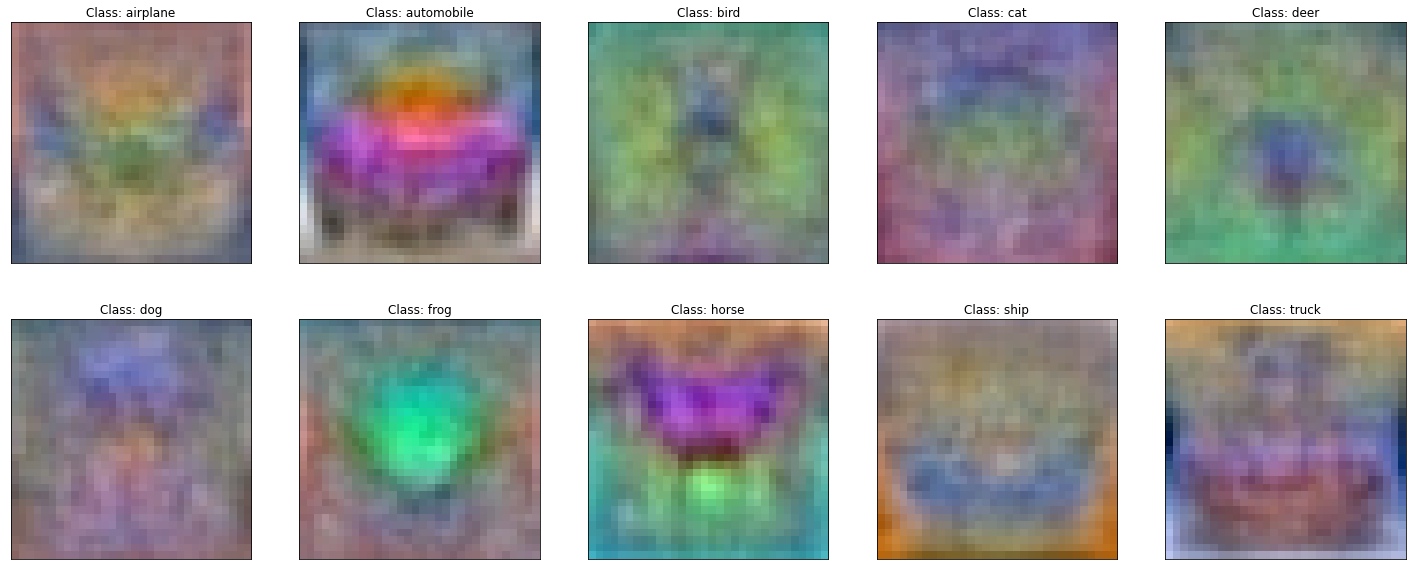

In [22]:
# ------Plotting learning rate, training and testing loss and accuracies-------
fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
items = {"Loss":loss_history, "Training Accuracy":train_acc_history,\
         "Validation Accuracy": val_acc_history, "Learning Rate":lr_hitory}
location = 1
for key in items.keys():
    plt.subplot(1,4,location);plt.plot(items[key], color='#0000ff', linewidth=4)
    plt.title(key)
    location+=1
saveto("part1plots.eps")

# -------------------Showing the weights matrix W1 as 10 images-----------------
weights = w1[1:,] # Removing the row of bias terms.
weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
location = 1 # Location of the image in the grid of 2x5
for i in range(K):
    image = images[:,i].reshape(32,32,3)
    plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
    plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
    saveimg("Reg Image "+ str(i)+".jpg", image)
    location+=1
saveto("trainedWeightslc.eps")

# Part 2
Code a two-layer fully connected network with H = 200 hidden nodes. Choose the sigmoid function as the activation function for the hidden nodes. The output layer has no activation function. [3 marks]

1. Implement gradient descent and run for 300 epochs.
2. Report the (initial) learning rate, training and testing loss and accuracies.

In [27]:
# Loading the Data Set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape); print('y_train: ', y_train.shape)
#print(y_train[0:10])

print("Pre-processing loaded data...\n")
# y_train contains labels form 0 to 9 corresponding to 10 classes.
K = len(np.unique(y_train)) # Number of Classes

Ntr = x_train.shape[0]; print('Number of training samples:', Ntr) # Number of training samples 50,000
Nte = x_test.shape[0]; print('Number of test samples: ',Nte,'\n')      # Number of test samples 10,000
Din = 3072 # CIFAR10 # 32x32x3 = height x width x channel

# Image data preprocessing
"""
Remove the normalization. Otherwise the model will not learn.
Because when the weights are extrememly small,
weight matrix will consist of almost the same elements.
and learning will stop.
"""
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0) # axis=0: mean of a column; Mean of each pixel
x_train = x_train - mean_image
x_test = x_test - mean_image

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K); print('y_train: ', y_train.shape); #print(y_train[0:10,:])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K); #print(y_test[0:10,:])

x_train = np.reshape(x_train,(Ntr,Din)).astype('float32');# print(x_train[0:10, 0:20])
x_test = np.reshape(x_test,(Nte,Din)).astype('float32')
print('Reshaped x_train: ', x_train.shape)
print('Reshaped x_test: ', x_test.shape)
print("Pre-processing completed.")

x_train:  (50000, 32, 32, 3)
y_train:  (50000, 1)
Pre-processing loaded data...

Number of training samples: 50000
Number of test samples:  10000 

y_train:  (50000, 10)
Reshaped x_train:  (50000, 3072)
Reshaped x_test:  (10000, 3072)
Pre-processing completed.


In [28]:
H = 200 # No of hidden nodes
print("Initializing the weight matrix with random weights...")
std=1e-5 # For random samples from N(\mu, \sigma^2), use: sigma * np.random.randn(...) + mu

# Hidden Layer 
w1 = std*np.random.randn(Din, H) # Initializing the weight matrix with random weights
b1 = np.zeros(H) # Initializing the bias vector
print("w1:", w1.shape);print("b1:", b1.shape)

# Last Layer
w2 = std*np.random.randn(H, K) # Initializing the weight matrix with random weights
b2 = np.zeros(K) # Initializing the bias vector
print("w2:", w2.shape);print("b2:", b2.shape)

print("Rearranging train and test samples...")
# Rearranging train and test samples: (ra=rearranged)
x_train_ra = np.concatenate((np.ones((x_train.shape[0],1)),x_train), axis=1); print('Rearranged x_train: ', x_train_ra.shape)
x_test_ra  = np.concatenate((np.ones((x_test.shape[0],1)),x_test), axis=1)

# Rearranging weight matrices and bias vectors into single matrices
w1 = np.concatenate((b1.reshape(1,H), w1), axis=0); print('Rearranged w1: ',w1.shape)
w2 = np.concatenate((b2.reshape(1,K), w2), axis=0); print('Rearranged w2: ',w2.shape)

print("Rearranging completed.")

iterations = 300  # Gradient descent interations
lr = 1.4e-2 # Learninig rate
lr_decay= 0.999
reg = 5e-6
lr_hitory = []
loss_history = [] # Vlaues of cost function at each iteration 
train_acc_history = []
val_acc_history = []

m = x_train.shape[0]  # Number of training examples

# Running gradient descent number of times speciied in iterations
print("Running gradient descent...")

for t in range(1,iterations+1):
    # Forward Propagation
    hypo = sigmoid(x_train_ra.dot(w1)) # Layer 1 with sigmoid activation
    hypothesis = np.concatenate((np.ones((hypo.shape[0],1)),hypo), axis=1) # Rearranging for layer 2
    predict = hypothesis.dot(w2) # Layer 2 
    
    loss = (1/(2*m))*np.sum(( predict - y_train)**2)\
         + (1/(2*m))*reg*np.sum(w1**2) + (1/(2*m))*reg*np.sum(w2**2)
    loss_history.append(loss)
            
    # Training Accuracy 
    train_acc = getAccuracy(predict, y_train)
    train_acc_history.append(train_acc)
    
    # Validation Accuracy
    test_hypo = sigmoid(x_test_ra.dot(w1))
    test_hypothesis = np.concatenate((np.ones((test_hypo.shape[0],1)),test_hypo), axis=1)# Rearranging for layer 2
    test_predict = test_hypothesis.dot(w2)
    valid_acc = getAccuracy(test_predict, y_test)
    val_acc_history.append(valid_acc)
    
    # Print details for selected iterations
    if (t%30==0) or (t==1):
        print("| Epoch {:03} | Loss {:.5f} | Training Acc: {:.5f} | Validation Acc: {:.5f} | Learning Rate: {:.5f} |"\
             .format(t,loss,train_acc,valid_acc,lr))
    
    # Back Propagation partial dertivatives of Loss function
    # (dl/dw2) = (dl/dpredict)(dpredic/dw2)
    dpredict =  (1/m)*(predict - y_train)
    dw2 = hypothesis.T.dot(dpredict) + (1/m)*reg*w2
    
    # (dl/dw1) = (dl/dh)(dh/dw1)
    # (dl/dw1) = (dl/dpredict)(dpredic/dh) * (dh/dw1x)(dw1x/dw1)
    dh = dpredict.dot(w2[1:,].T) # Removing bias vector w2(201x10)--> 200x10
    dhdxw1 = hypo*(1 - hypo) #using hypothesis 50000*200 before rearranging.
    dw1 = x_train_ra.T.dot(dh*dhdxw1) + (1/m)*reg*w1
    
#     dh = dpredict.dot(w2.T) # Removing bias vector w2(201x10)--> 200x10
#     dhdxw1 = hypothesis*(1 - hypothesis) #using hypothesis 50000*200 before rearranging.
#     dw1 = x_train_ra.T.dot(dh*dhdxw1)[:,1:] + (1/m)*reg*w1
    
    # Gradient Descent
    w1 = w1 - lr*dw1
    w2 = w2 - lr*dw2
    
    # Decaying learning rate
    lr_hitory.append(lr)
    lr = lr*lr_decay

    
print("Gradient Descent completed. Parameters were trained")

Initializing the weight matrix with random weights...
w1: (3072, 200)
b1: (200,)
w2: (200, 10)
b2: (10,)
Rearranging train and test samples...
Rearranged x_train:  (50000, 3073)
Rearranged w1:  (3073, 200)
Rearranged w2:  (201, 10)
Rearranging completed.
Running gradient descent...
| Epoch 001 | Loss 0.50000 | Training Acc: 10.00000 | Validation Acc: 10.00000 | Learning Rate: 0.01400 |
| Epoch 030 | Loss 0.42038 | Training Acc: 27.36800 | Validation Acc: 27.33000 | Learning Rate: 0.01360 |
| Epoch 060 | Loss 0.41031 | Training Acc: 33.58400 | Validation Acc: 33.83000 | Learning Rate: 0.01320 |
| Epoch 090 | Loss 0.40222 | Training Acc: 35.76200 | Validation Acc: 35.80000 | Learning Rate: 0.01281 |
| Epoch 120 | Loss 0.39463 | Training Acc: 38.95000 | Validation Acc: 38.66000 | Learning Rate: 0.01243 |
| Epoch 150 | Loss 0.39008 | Training Acc: 40.28200 | Validation Acc: 39.86000 | Learning Rate: 0.01206 |
| Epoch 180 | Loss 0.38801 | Training Acc: 40.71200 | Validation Acc: 40.06000 | 

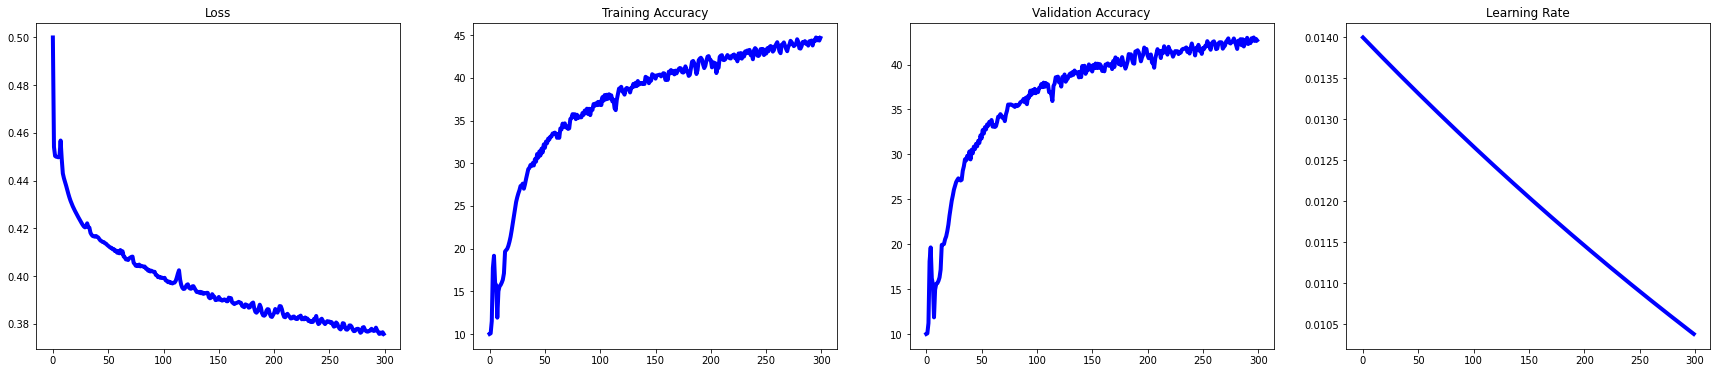

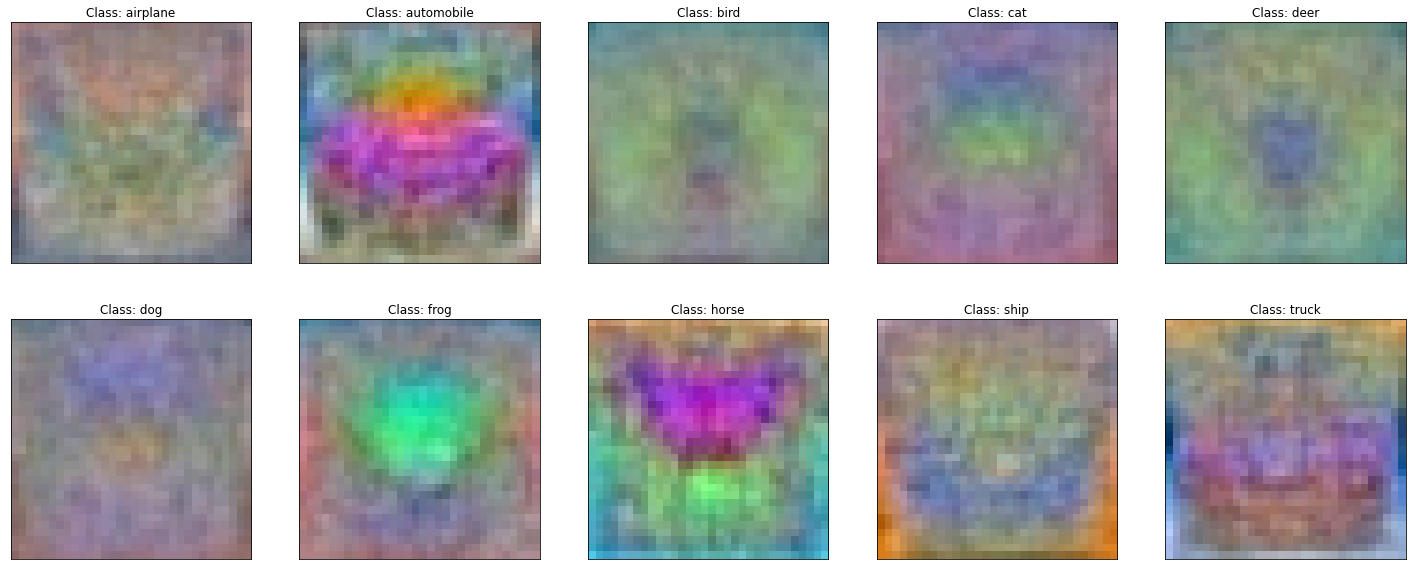

In [31]:
# ------Plotting learning rate, training and testing loss and accuracies-------
fig, axes  = plt.subplots(1,4, sharex='all', sharey='all', figsize=(30,6))
items = {"Loss":loss_history, "Training Accuracy":train_acc_history,\
         "Validation Accuracy": val_acc_history, "Learning Rate":lr_hitory}
location = 1
for key in items.keys():
    plt.subplot(1,4,location);plt.plot(items[key], color='#0000ff', linewidth=4)
    plt.title(key)
    location+=1
saveto("part2plots.eps")

# -------------------Showing the weights matrix W1.W2 as 10 images-----------------
weights = w1[1:,].dot(w2[1:,]) # Removing the rows of bias terms.
weights_pos =  weights- np.min(weights)# Making the minimum weight zero.
images = ((weights_pos/np.max(weights_pos))*255).astype('uint8')
CIFAR10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, axes  = plt.subplots(2,5, sharex='all', sharey='all', figsize=(25,10))
location = 1 # Location of the image in the grid of 2x5
for i in range(K):
    image = images[:,i].reshape(32,32,3)
    plt.subplot(2,5,location),plt.imshow(image[:,:,::-1])
    plt.title("Class: {}".format(CIFAR10[i])),plt.xticks([]),plt.yticks([])    
    saveimg("Reg Image "+ str(i)+".jpg", image)
    location+=1
saveto("trainedWeightsnn2.eps")

# Part 3

Modify the code in item 2 to carry out stochastic gradient descent with a batch size of 500. [2 marks]
1. Report training and testing loss and accuracies.
2. Compare results with item2 (justify).

In [ ]:
# batch_size = 500 # --> Using all the training examples
# seed = 0
# rng = np.random.default_rng(seed=seed)
# for t in range(iterations):
#     indices = np.arange(batch_size)
#     rng.shuffle(indices)
#     x_train = x_train[indices]
#     y_train = y_train[indices]
#     x_test  =  x_test[indices]
#     y_test  =  y_test[indices]
    
# print(rng)
# indices = np.arange(Ntr)
# rng.shuffle(indices)
# set = indices[0:5]
# print('set :', set)
# print(x_train[set])

# Part 4 
Construct a CNN using Keras.models.Sequential (with the following configuration: C32, C64, C64, F64, F10. All three convolutions layers are 3x3. Max pooling (2x2) follows each convolution layer. Use SDG (with momentum) with a batch size of 50 and CategoricalCrossentropy as the loss. [2
marks]
1. How many learnable parameters are there in this network?
2. Report the parameters such as the learning rate and momentum.
3. Report training and testing loss and accuracies.